In [1]:

from text_loader_utils import TextLoader
import cPickle
import numpy as np
import tensorflow as tf
from variational_model import NVDM
from vector_utils import find_norm
from tf_common_utils import load_model , save_model

np.random.seed(0)
tf.set_random_seed(0)

def xavier_init(fan_in , fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
#     fan_in = in_and_out[0]
#     fan_out = in_and_out[1]
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

In [2]:
from sklearn.datasets import fetch_20newsgroups
twenty_train = fetch_20newsgroups(subset='train')   
data_ = twenty_train.data
print "Download 20 news group data completed"
A = TextLoader(data_ , min_count = 25)
batch_size = 100
    # restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)
# initialize the Session

In [3]:
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_opts))

In [4]:
vae = NVDM(sess , len(A.vocab), 50, [500 , 500] ,  
                         transfer_fct=tf.nn.tanh , output_activation=tf.nn.softmax,
                         batch_size=100, initializer=xavier_init )

In [5]:
vae.start_the_model()

In [6]:
load_model(vae)


True

In [7]:
embedding_matrix = vae.SESS.run(vae.Weights_generator['out_mean'])

In [8]:
embedding_matrix.shape

(50, 8466)

In [9]:
embedding_matrix = embedding_matrix.transpose()
embedding_matrix = find_norm(embedding_matrix) ####### Normalizing the matrix helps to find cosine similarity so fast

In [10]:
from vector_utils import find_similar
def word_match(norm_mat , word_ , vocab, vocab_inverse , topN = 10):
    
    idx = vocab[word_]
    similarity_meas , indexes = find_similar(norm_mat , norm_mat[idx])
    words = [vocab_inverse[i_x_] for i_x_ in indexes[:topN]]
    return zip(words , similarity_meas[:topN])

In [21]:
word_match(embedding_matrix , 'football' , A.vocab , A.vocab_inverse  )

[('football', 1.0000001),
 ('stadium', 0.85528636),
 ('basketball', 0.8517698),
 ('philly', 0.83852005),
 ('mlb', 0.83592558),
 ('robbie', 0.83328015),
 ('anyways', 0.82795608),
 ('seats', 0.82188618),
 ('miami', 0.82166839),
 ('champs', 0.81938583)]

In [ ]:
################# Pickup the hidden dimensions for all 20 news groups
batch_size = 100
H_20_grp_nws = []
batch_data = A.get_batch(batch_size)
batch_id = 0
for batch_ in batch_data:

            batch_id += 1
            collected_data = [chunks for chunks in batch_]
            batch_xs , mask_xs , mask_negative  = A._bag_of_words(collected_data)
            

            feed_dict = {vae.X: batch_xs , vae.dynamic_batch_size:batch_xs.shape[0],
                                            vae.MASK:mask_xs}

            h_batch    = vae.SESS.run(vae.z, feed_dict= feed_dict)
            H_20_grp_nws.extend(h_batch)

H_20_grp_nws = np.array(H_20_grp_nws)
from sklearn import manifold
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
%time H_tsne = tsne.fit_transform(H_20_grp_nws) ########### Converting to tsne



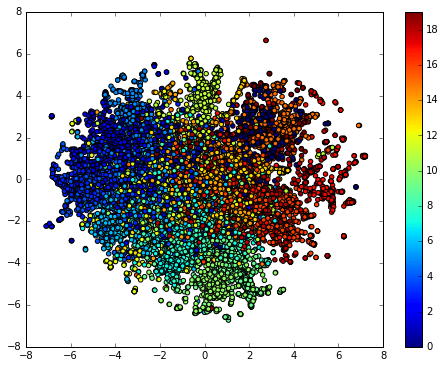

In [34]:


import matplotlib.pyplot as plt

%matplotlib inline


############ Picking only non - null values after pre-processing ( The non null indexes of data is in self.data_index)
newsgroups_target = [twenty_train.target[i] for i in A.data_index]
########### Converting targets to One-hot-K Vectors by tf.one_hot for visualization purposes
news_target_one_hot = sess.run(tf.one_hot(newsgroups_target , depth=len(set(newsgroups_target))))



plt.figure(figsize=(8, 6)) 
plt.scatter(H_tsne[:, 0], H_tsne[:, 1], c=np.argmax(news_target_one_hot, 1))
plt.colorbar()


In [67]:

def find_similiar_docs(index, topN = 10):

    a , b = find_similar(find_norm(H_20_grp_nws), find_norm(H_20_grp_nws)[index])
    source = data_[index]
    similar_results = [data_[i] for i in b[1:topN]]
    
    return source , zip(similar_results, a[1:topN])

In [68]:
query , res = find_similiar_docs(1797)

In [69]:
query

u'From: rlglende@netcom.com (Robert Lewis Glendenning)\nSubject: Don\'t fight Clipper Chip, subvert or replace it !\nOrganization: Netcom - Online Communication Services (408 241-9760 guest)\nDistribution: na\nLines: 35\n\nClipper Chip is a response to the fact that there is no business\nor professional body in a position to establish a standard and\nprovide chipsets to implement it for analog or digial transmission\nsystems.\n\nRSA might be in position to do it, if they had active cooperation of\na couple of manufacturers of cellular phones or desktop phones.\n\nLarge companies in the voice/data comm business are out, because they\nall have contracts with the gov which would be used to pressure them.\n\nIf we, as professionals in crypto organizations, EFF, etc. were to\nput our collective minds and interests toward establishing a\ncrypto standard for transmission, and getting our companies to\nimplement it, we might avoid government control.\n\nOtherwise, I think it will happen to us 

In [70]:
res

[(u'From: tcmay@netcom.com (Timothy C. May)\nSubject: Re: Don\'t fight Clipper Chip, subvert or replace it !\nOrganization: NETCOM On-line Communication Services (408 241-9760 guest)\nX-Newsreader: Tin 1.1 PL5\nDistribution: na\nLines: 87\n\nRobert Lewis Glendenning (rlglende@netcom.com) wrote:\n: Clipper Chip is a response to the fact that there is no business\n: or professional body in a position to establish a standard and\n: provide chipsets to implement it for analog or digial transmission\n: systems.\n: \n: RSA might be in position to do it, if they had active cooperation of\n: a couple of manufacturers of cellular phones or desktop phones.\n.......\n: Is RSA independt of the gov enough to spearhead this?  I, for one,\n: would *gladly* pay royalties via purchasing secure phones.\n\n\nHear hear! I completely agree that we need to work quickly to\nestablish alternatives to the government\'s Clinton Clipper. As Brad\nTempleton and others have noted, once the Clipper becomes ensconce